# Figure 1. Meta-analysis of human islets.
*Xueqin Xie*  
*2025/05/25*

(A) Integration of human islet scRNA-seq for meta-analysis. ND: non-diabetic; preT2D: pre-diabetic; T2D: type 2 diabetes. (B) Unsupervised clustering from 495,945 pancreatic islet cells, with cell annotations visualized on UMAP coordinates. The number of cells for each cell type is displayed as a bar plot in the right panel. (C) Dual-cell enriched markers for beta-delta and alpha-gamma cells. Values represent average expression after mean-centering and scaling (z-score) across cell types. Negative values indicate expression below the gene's average across cell types. (D) Scatter plots of average log2 fold-change expression (y-axis) detected between T2D and ND from ten cell types (x-axis) at pseudobulk level. endoth: endothelial; macro: macrophage. Genes with an adjusted p-value < 0.05 were considered statistically differentially expressed. Adjusted p-values were derived from pseudobulk differential expression analysis using DESeq2 with Benjamini-Hochberg (BH) correction. (Top) Violin plots highlight examples of differentially expressed genes between T2D and ND in beta cells. * p.adj < 0.05, ** p.adj < 0.01, *** p.adj < 0.001. (E) Gene set enrichment analysis of cell-type-specific genes in endocrine cells. (F) Epsilon-cell-specific expression in growth hormone synthesis, secretion, and action pathway. Genes marked with * represent epsilon cell-specific markers. Relative gene expression is shown in pseudo colour. Values represent z-score normalized average expression across cell types (mean-centered and scaled per gene). VSCC-L: voltage sensitive calcium channel L-type; GH: growth hormone; GHSR: GH secretagogue receptor;  Gq: G protein alpha q subunit; IP3: inositol triphosphate; IP3R: IP3 receptor; GHRH: GH-releasing hormone; GHRH-R: GHRH receptor;  Gs: G protein alpha stimulatory subunit; AC: adenylate cyclase; cAMP: cyclic adenosine monophosphate; PKA: protein kinase A; CREB: cAMP-response element binding protein; SSTR: somatostatin receptor; Gi: G protein alpha inhibitory subunit; GHR: GH receptor; JAK2: Janus kinase 2; FAK: focal adhesion kinase; p38: p38 mitogen-activated protein kinase; SHC: SHC-transforming protein; Ras: GTPase HRas; ERK: extracellular signal-regulated kinase.

### Figure 1(A)

`summarise()` has grouped output by 'Data_source'. You can override using the `.groups` argument.


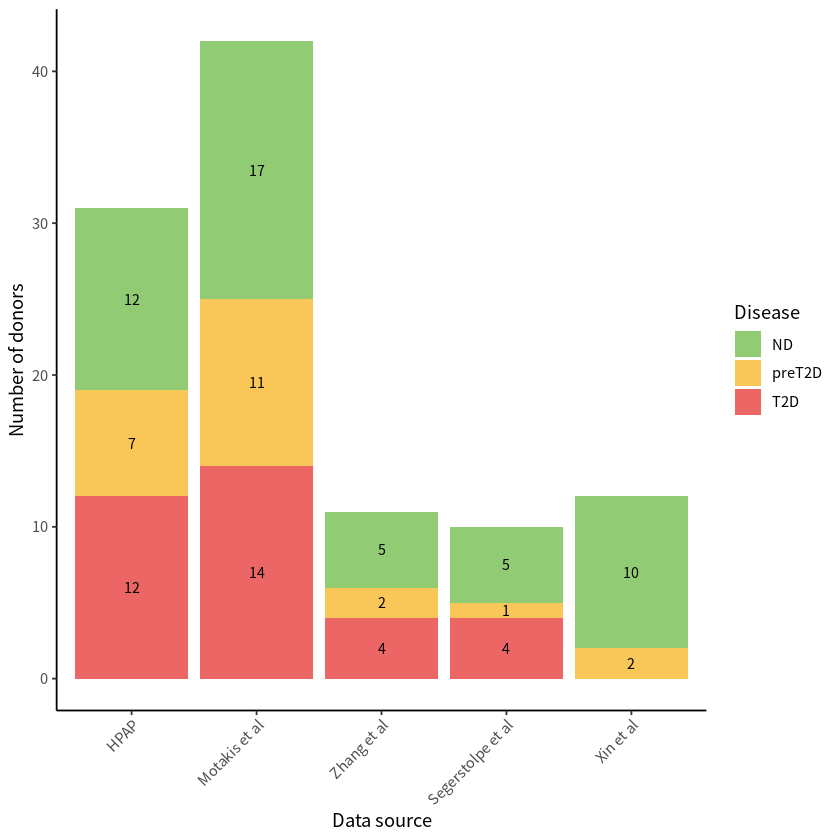

In [2]:
library(ggplot2)
library(dplyr)

donor_df = read.csv("./All_donor_infor.csv",header = T)

donor_summary = donor_df %>%
  group_by(Data_source, Disease) %>%
  summarise(Donor_count = n_distinct(Donor)) %>%
  ungroup() %>%
  mutate(
    Data_source = factor(Data_source, levels = c('HPAP','Motakis et al','Zhang et al','Segerstolpe et al','Xin et al')),
    Disease = factor(Disease, levels = c("ND", "preT2D", "T2D")))

ggplot(donor_summary, aes(x = Data_source, y = Donor_count, fill = Disease)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = Donor_count),
            position = position_stack(vjust = 0.5),
            size = 3) +
  scale_fill_manual(values = c("ND" = "#91cc75", "preT2D" = "#f9c757", "T2D" = "#ed6666")) +
  labs(x = "Data source", y = "Number of donors", fill = "Disease") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

### Figure 1(B)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


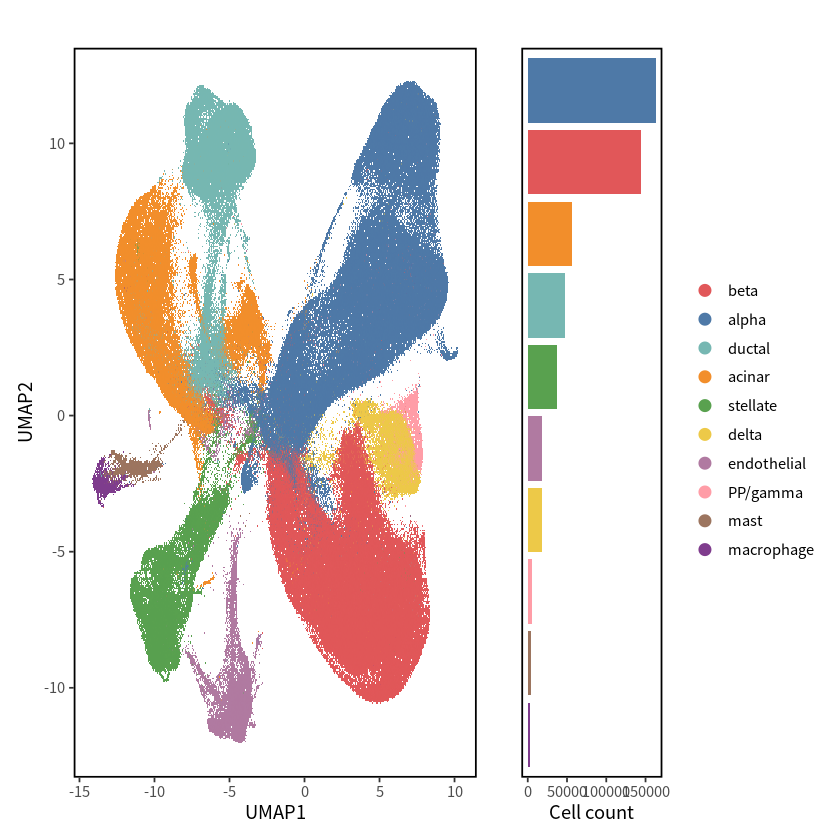

In [8]:
library(cowplot)
library(patchwork)
library(Seurat) 

panc_integrated = readRDS("./integrated_data.rds")
cell_counts = as.data.frame(table(panc_integrated$cell_type))

mycol= c("#E15759", "#4E79A7", "#76B7B2", "#F28E2B", "#59A14F", "#EDC948", "#B07AA1", "#FF9DA7", "#9C755F","#7F3C8D")
p_umap = DimPlot(panc_integrated, reduction = "umap.harmony", group.by = "cell_type") +
  scale_color_manual(values = mycol) +
  labs(title = "") +
  theme_bw() +
 labs(x = "UMAP1", y = "UMAP2") +
  theme(
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), 
    panel.border = element_rect(color = "black", size = 1)) 
  
p_bar = ggplot(cell_counts, aes(x = reorder(Var1, Freq), y = Freq, fill = Var1)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  scale_fill_manual(values = mycol) +
  labs(x = "", y = "Cell count") +
  theme_bw() +
  theme( 
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), 
    axis.ticks.y = element_blank(),
    axis.text.y = element_blank(),
    legend.position = "none",
    panel.border = element_rect(color = "black", size = 1))  

cell_legend = get_legend(p_umap)
p_umap = p_umap + theme(legend.position = "none")
p_umap + p_bar + cell_legend + plot_layout(widths = c(2,0.7,0.7))

### Figure 1(C)

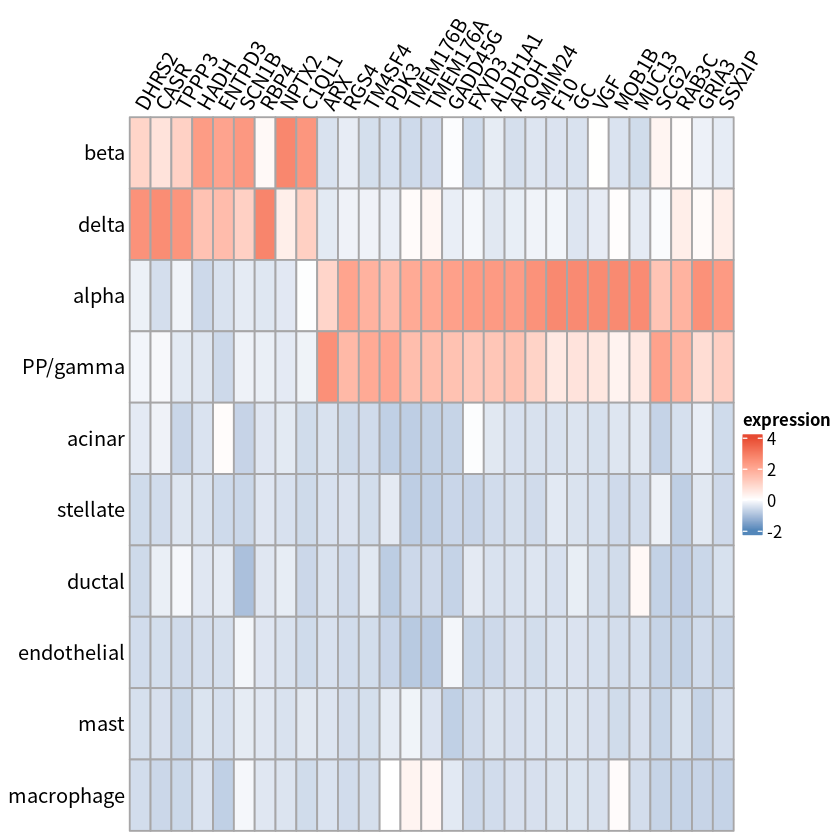

In [16]:
library(circlize)
library(ComplexHeatmap)

aver_exp = AverageExpression(panc_integrated, group.by = 'cell_type', layer = 'data')
aver_exp = as.data.frame(aver_exp$RNA)
aver_exp = t(scale(t(aver_exp)))

overlap_markers = read.csv("./overlap_markers.csv",header = T)
genes = c(overlap_markers$beta.delta,overlap_markers$alpha.PP)
genes = unique(genes)
genes = genes[genes != ""]

aver_exp2 = aver_exp[genes,]
aver_exp2 = aver_exp2[,c("beta","delta","alpha","PP/gamma","acinar","stellate","ductal","endothelial","mast","macrophage")]

mycol = colorRamp2(c(-2, 0, 4), c("#5387ba", "white", "#e74a32"))
Heatmap(t(aver_exp2),
        name = 'expression',
        cluster_columns = F,cluster_rows = F, 
        col = mycol,rect_gp = gpar(col = "#a7a6a7", lwd = 1.5),
        column_names_side = c('top'),
        row_names_side = c('left'),
        column_names_rot = 60)

### Figure 1(D)


     acinar       alpha        beta       delta      ductal endothelial 
         10          20          91           8           9           5 
 macrophage    PP/gamma    stellate 
          1           1          11 

Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“ggrepel: 25 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


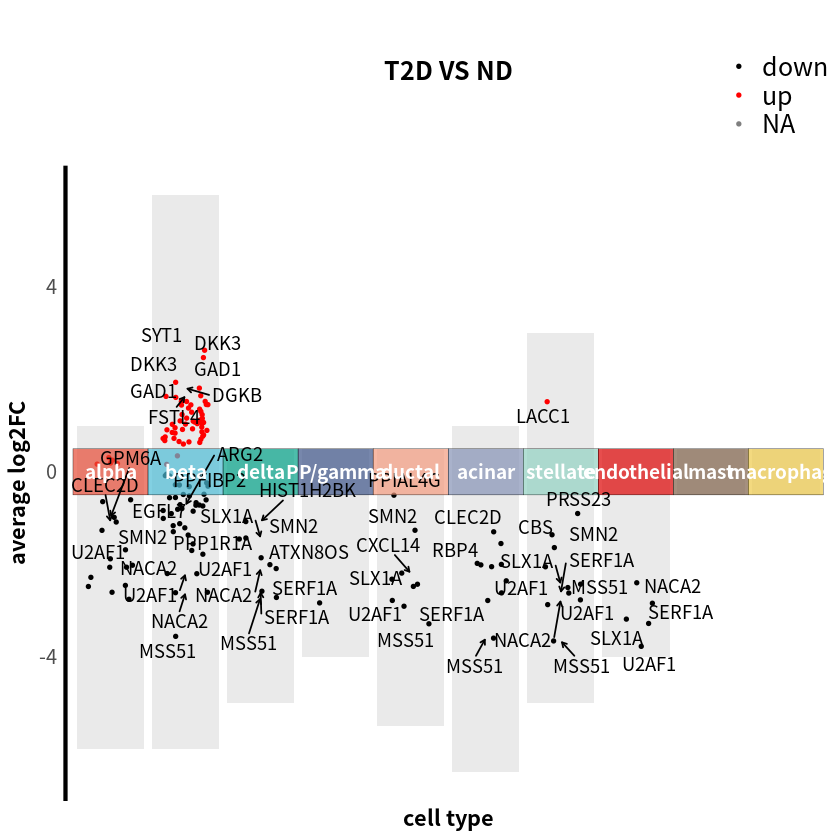

In [45]:
cell_markers_2 = readRDS("./degs_ND_T2D_donor_label_based.rds")

# volcano plot -- T2D VS ND
library(ggrepel)
results_list = list()
# beta
results_list[["beta"]] = cell_markers_2$beta %>%
  filter(pct.1 > 0.65 | pct.2 > 0.65) %>%
  mutate(FC_category = case_when(
    avg_log2FC > 0 ~ "positive",
    avg_log2FC < 0 ~ "negative"
  )) %>%
  group_by(FC_category) %>%
  top_n(60, abs(avg_log2FC)) %>%
  arrange(avg_log2FC)

# alpha, delta, gamma,endothelial
for (cell in c("alpha","delta","endothelial","PP/gamma")) {
  results_list[[cell]] = cell_markers_2[[cell]] %>%
    filter(pct.1 > 0.40 | pct.2 > 0.40) }

# ductal, acinar, stellate
for (cell in c("ductal","acinar","stellate")) {
  results_list[[cell]] = cell_markers_2[[cell]] %>%
    filter(pct.1 > 0.38 | pct.2 > 0.38) 
}

# mast, macrophage
results_list[["mast"]] = cell_markers_2$mast
results_list[["macrophage"]] = cell_markers_2$macrophage

results_df =  bind_rows(results_list, .id = "cell") %>%
  mutate(cell = factor(cell)) 

new_row = data.frame(matrix(NA, nrow = 1, ncol = 8))
colnames(new_row) = colnames(results_df)
new_row[1,1] = 'macrophage'
results_df = rbind(results_df, new_row)

table(results_df$cell)
results_df$label = ifelse(results_df$avg_log2FC>0,"up","down")

# top label gene
top_list = list()

for (cell_type in c("delta","endothelial","PP/gamma","ductal","acinar","stellate","mast","macrophage")) {
  top_list[[cell_type]] = results_df %>%
    filter(cell == cell_type) }

for (cell_type in c("beta","alpha")) {
  top_list[[cell_type]] = results_df %>%
    filter(cell == cell_type) %>%
    group_by(FC_category) %>%
    top_n(5, abs(avg_log2FC)) }


top_list = list()

for (cell_type in c("delta","endothelial","PP/gamma","ductal","acinar","stellate","mast","macrophage")) {
  
  top_list[[cell_type]] = results_df %>%
    filter(cell == cell_type) 
  
}

for (cell_type in c("beta","alpha")) {
  
  top_list[[cell_type]] = results_df %>%
    filter(cell == cell_type) %>%
    group_by(FC_category) %>%
    top_n(5, abs(avg_log2FC)) 
  
}


top_df = bind_rows(top_list)
top_df = rbind(top_df, results_df[which(results_df$cell == "beta"& results_df$gene == "PPFIBP2"),])
top_df = rbind(top_df, results_df[which(results_df$cell == "beta"& results_df$gene == "PPP1R1A"),])
top_df = rbind(top_df, results_df[which(results_df$cell == "beta"& results_df$gene == "ARG2"),])
top_df = rbind(top_df, results_df[which(results_df$cell == "beta"& results_df$gene == "EGFL7"),])
top_df = rbind(top_df, results_df[which(results_df$cell == "beta"& results_df$gene == "DKK3"),])
top_df = rbind(top_df, results_df[which(results_df$cell == "beta"& results_df$gene == "GAD1"),])

top_df = rbind(top_df, results_df[which(results_df$cell == "alpha"& results_df$gene == "CLEC2D"),])
top_df = rbind(top_df, results_df[which(results_df$cell == "alpha"& results_df$gene == "GPM6A"),])
top_df = rbind(top_df, results_df[which(results_df$cell == "alpha"& results_df$gene == "NACA2"),])
top_df = rbind(top_df, results_df[which(results_df$cell == "alpha"& results_df$gene == "U2AF1"),])
top_df = rbind(top_df, results_df[which(results_df$cell == "alpha"& results_df$gene == "SMN2"),])
top_df = rbind(top_df, results_df[which(results_df$cell == "alpha"& results_df$gene == "SERF1A"),])


cell_order = c("alpha", "beta", "delta","PP/gamma","ductal","acinar","stellate","endothelial","mast","macrophage")
results_df$cell = factor(results_df$cell,levels = cell_order)


dfcol  = data.frame(x = cell_order,y = 0,label=c(0:9))
dfcol$x = factor(dfcol$x, levels = cell_order)

mycol = c("#E64B357F","#4DBBD57F","#00A0877F","#3C54887F","#F39B7F7F","#8491B47F","#91D1C27F","#DC00007F","#7E61487F","#EDC948")
dfbar = data.frame(x = cell_order,y = c(1,6,0.5,0.5,0.5,1,3,0.5,0.5,0.5))
dfbar1 = data.frame(x = cell_order,y = c(-6,-6,-5,-4,-5.5,-6.5,-5,-4,-0.5,-0.5))

ggplot()+
  geom_col(data = dfbar,mapping = aes(x = x,y = y),fill = "#dcdcdc",alpha = 0.6)+
  geom_col(data = dfbar1,mapping = aes(x = x,y = y),fill = "#dcdcdc",alpha = 0.6)+
  geom_jitter(data = results_df,aes(x = cell, y = avg_log2FC, color = label),size = 0.85,width =0.3)+
  geom_tile(data = dfcol,aes(x=x,y=y),height=1,color = "black",fill = mycol, alpha = 0.7, show.legend = F) + 
  geom_text_repel(data = top_df,aes(x=cell,y=avg_log2FC,label=gene),force = 1.2,arrow = arrow(length = unit(0.008, "npc"),type = "open", ends = "last")) + 
  scale_color_manual(name=NULL,values = c("black","red")) +
  geom_text(data = dfcol,aes(x=x,y=y,label=x),size = 4,color ="white",fontface = "bold") +
  theme_minimal() + 
  labs(x = "cell type", y = "average log2FC",title = "T2D VS ND") +
  theme(
    axis.title = element_text(size = 13,color = "black",face = "bold"),
    axis.line.y = element_line(color = "black",size = 1.2),
    axis.line.x = element_blank(),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text.y = element_text(size = 12),
    legend.position = "top",
    legend.direction = "vertical",
    legend.justification = c(1,0),
    legend.text = element_text(size = 15),
    plot.title = element_text(hjust = 0.5, size = 15, face = "bold",vjust = -8.5)) 

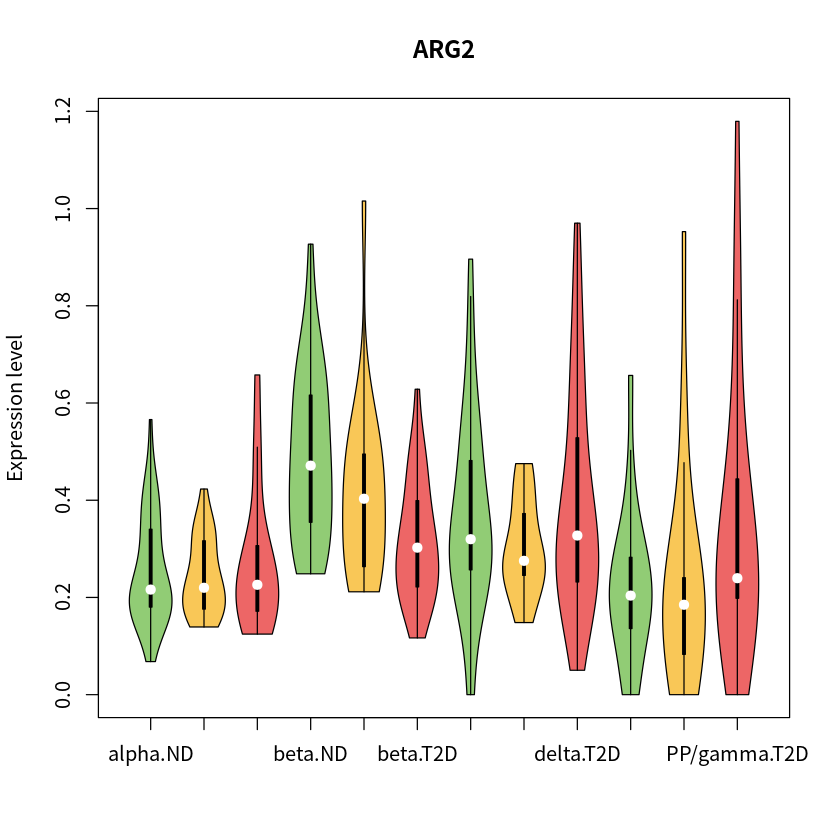

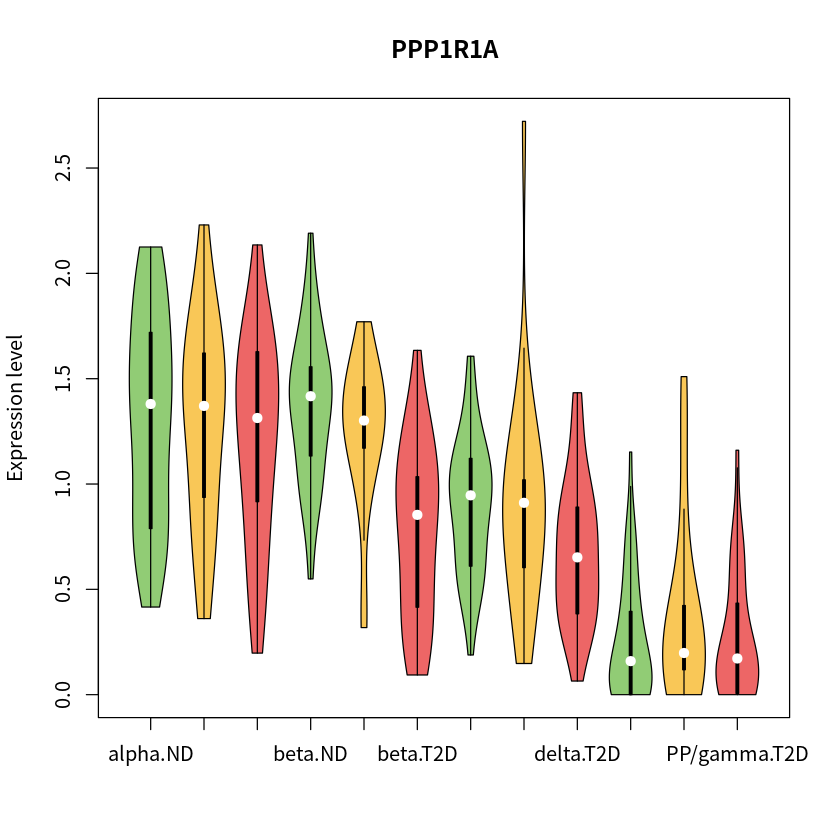

In [50]:
library(vioplot)

cell_disease = c("alpha.ND","alpha.preT2D","alpha.T2D","beta.ND","beta.preT2D","beta.T2D",
                 "delta.ND","delta.preT2D","delta.T2D","PP/gamma.ND","PP/gamma.preT2D","PP/gamma.T2D")

data = FetchData(panc_bulk, vars = c("ARG2","PPP1R1A","cell_type", "disease_status"))

genes = c("ARG2","PPP1R1A")

for (gene in genes) {
  split_data = split(data, list(data$cell_type, data$disease_status))
  violin_data = list()
  for (name in names(split_data)) {
    violin_data[[name]] = split_data[[name]][,gene]
  }
  
  violin_data = violin_data[cell_disease]
  vioplot(violin_data, names = names(violin_data),col = c("ND" = "#91cc75", "preT2D" = "#f9c757", "T2D" = "#ed6666"))
  title(main = gene, ylab = "Expression level", xlab = "")
  
}


### Figure 1(E)
Figure 1E was created using Adobe Illustrator (AI) to visually present the conceptual design.

### Figure 1(F)

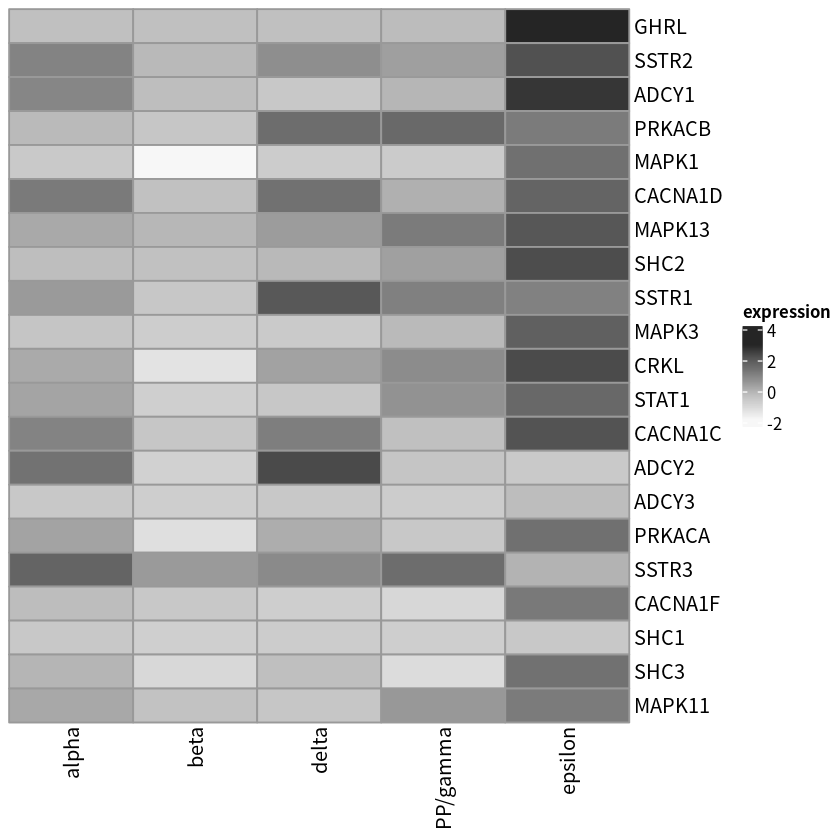

In [6]:
library(tidyr)
library(RColorBrewer)

aver_exp = AverageExpression(panc_integrated, group.by = 'cell_type', layer = 'data')
aver_exp = as.data.frame(aver_exp$RNA)
aver_exp = t(scale(t(aver_exp)))

gh_genes = readRDS("./epsilon_degs.rds")

aver_exp2 = aver_exp[gh_genes,c("alpha","beta","delta","PP/gamma","epsilon")]
color = colorRampPalette(brewer.pal(n = 7, name ="Greys"))(50)
ht = Heatmap(aver_exp2,cluster_columns = F,cluster_rows = F,col = color,
             rect_gp = gpar(col = "#999999", lwd = 1.5),name = 'expression')
dht = draw(ht)
dht